This file presents a bunch of pretty pictures spanning various topics. We start with a representation of the boxy box algorithm in 2D for the Toggle Switch, then an investigation into the corners of the boxy box for EMT, finally a discussion on the parameter regions of the Toggle Switch.

# The Boxy Box algorithm

parameter in center region


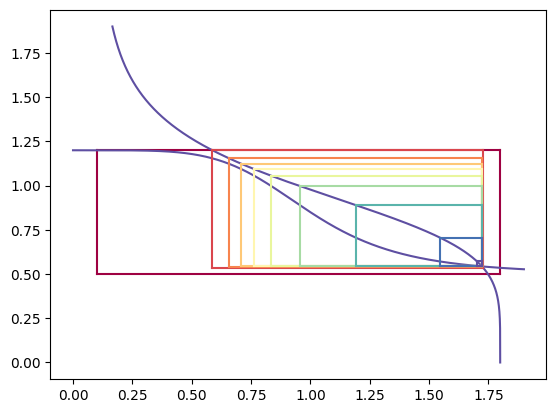

boxy box converged
detected monostability
   AGAINST DSGRN predictions


In [14]:
import numpy as np
import matplotlib.pyplot as plt

cmap = plt.cm.get_cmap('Spectral')

gamma1, ell1, delta1 = 1, .5, .7
gamma2, ell2, delta2 = 1, .1, 1.7

theta1 = 1.#gamma1/(ell1 + delta1/2)
theta2 = 1.#gamma2/(ell2 + delta2/2)

n = 5.

in_center_region = (ell1<gamma1*theta1) and (gamma1*theta1< ell1+delta1) and (ell2<gamma2*theta2) and (gamma2*theta2<ell2+delta2)

if in_center_region:
    print('parameter in center region')
else:
    print('parameter NOT in center region')

H1 = lambda x : ell1 + delta1 /( 1 + (x/theta1)**n)
H2 = lambda x : ell2 + delta2 /( 1 + (x/theta2)**n)



x1_min, x1_max = ell1/gamma1, (ell1 + delta1)/gamma1
x2_min, x2_max = ell2/gamma2, (ell2 + delta2)/gamma2
 
plt.plot([x2_min, x2_max],[x1_min, x1_min],color=cmap(0))
plt.plot([x2_min, x2_min],[x1_min, x1_max],color=cmap(0))
plt.plot([x2_max, x2_max],[x1_min, x1_max],color=cmap(0))
plt.plot([x2_min, x2_max],[x1_max, x1_max],color=cmap(0)) 
    
x_min = min(x1_min, x2_min)
x_max = max(x1_max, x2_max)
xplot = np.linspace(x_min-0.1, x_max+0.1, 1000)
plt.plot(xplot, H1(xplot)/gamma1,color=cmap(1000))
plt.plot(H2(xplot)/gamma2, xplot,color=cmap(1000))


for i in range(1,20):
    x1_min = H1(x2_max)/gamma1
    x1_max = H1(x2_min)/gamma1
    x2_min = H2(x1_max)/gamma2
    x2_max = H2(x1_min)/gamma2
    plt.plot([x2_min, x2_max],[x1_min, x1_min],color=cmap(i*30))
    plt.plot([x2_min, x2_min],[x1_min, x1_max],color=cmap(i*30))
    plt.plot([x2_max, x2_max],[x1_min, x1_max],color=cmap(i*30))
    plt.plot([x2_min, x2_max],[x1_max, x1_max],color=cmap(i*30)) 

plt.savefig('boxy_box')
plt.show()

if abs(-gamma1*x1_min + H1(x2_max))>10**-6 and abs(-gamma1*x1_max + H1(x2_min))>10**-6:
    print('boxy box FAILED to converge')
else:
    print('boxy box converged')

bistability = abs(x1_min - x1_max)>10**-6 and abs(x2_min - x2_max)>10**-6
if bistability:
    print('detected bistability')
else:
    print('detected monostability')
    if in_center_region: 
        print('   AGAINST DSGRN predictions')


# EMT, actually actually working!

def EMT:


$$
\begin{cases}
x1dot = -gamma1 * x[0] + Hmin(p12, x[1])*Hmin(p14, x[3])\\

x2dot = -gamma2 * x[1] + Hmin(p23, x[2])*Hplus(p25, x[4])\\

x3dot = -gamma3 * x[2] + Hmin(p36, x[5])*Hplus(p31, x[0])\\

x4dot = -gamma4 * x[3] + Hmin(p45, x[4])\\

x5dot = -gamma5 * x[4] + Hmin(p54, x[3])*Hplus(p52, x[1])*Hplus(p53, x[2])\\

x6dot = -gamma6 * x[5] + Hmin(p63, x[2])
\end{cases}
$$

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import itertools


def Hmin(n, par, x):
    ell, delta, theta = par[:]
    return ell + delta /( 1 + (x/theta)**n)


def H_bound():
    ell, delta, theta = 2.1, 3.4, 1.6
    return np.array((ell, ell+delta))


def Hplus(n, par, x):
    ell, delta, theta = par[:]
    if x == 0:
        return ell
    return ell + delta /( 1 + (theta/x)**n)


# the EMT right hand side

def gpm_func(n, par):
    gplus = lambda x : np.array((1, Hplus(n,par[7,:],x[4]), Hplus(n,par[8,:],x[0]), 1, 
                                 Hplus(n,par[9,:],x[1])*Hplus(n,par[10,:],x[2]), 1))

    gminus = lambda x : np.array((Hmin(n,par[0,:],x[1])*Hmin(n,par[1,:],x[3]), Hmin(n,par[2,:],x[2]), 
                              Hmin(n,par[3,:],x[5]), Hmin(n,par[4,:],x[4]), Hmin(n,par[5,:],x[3]), 
                              Hmin(n,par[6,:],x[2])))
    return gplus, gminus


def F_func(n,par, gamma):
    gplus, gminus = gpm_func(n,par)
    F = lambda x : - gamma * x + gplus(x) * gminus(x)
    return F


def phi_func(n,par, gamma):
    gplus, gminus = gpm_func(n,par)
    phi = lambda xplus, xminus : (gplus(xplus)*gminus(xminus)/gamma, gplus(xminus)*gminus(xplus)/gamma)
    return phi


def convergence(F, xminus, xplus):
    tol = 10**-7
    if np.linalg.norm(xminus-xplus)<tol:
        return True
    zero_corners = 0
    allx = list(itertools.product(*zip(xminus, xplus)))
    
    for i in range(2**6):
        if(np.linalg.norm(F(allx[i])))<tol:
            zero_corners += 1
    
    if zero_corners >= 2:
        return True
    else:
        return False

    
def which_corner(F, xminus, xplus):
    tol = 10**-7
    allx = list(itertools.product(*zip(xminus, xplus)))
    
    for i in range(2**6):
        if(np.linalg.norm(F(allx[i])))<tol:
            print(np.linalg.norm(F(allx[i])))

            
def boxy_box_from_pars(n, par, gamma, maxiter = 180):
    # define the mapping
    
    gplus, gminus = gpm_func(n, par)
    phi = phi_func(n, par, gamma)
    F = F_func(n, par, gamma)
    
    # set starting point
    xzero = np.zeros(6)
    x100 = 100 + xzero
    xplus, xminus = gplus(xzero)*gminus(x100)/gamma, gplus(x100)*gminus(xzero)/gamma
    
    # the iterations
    iter = 0
    remainder = np.array([])
    while (not convergence(F, xminus, xplus)) and (iter < maxiter):
        xplus_new, xminus_new = phi(xplus, xminus)
        remainder = np.append(remainder, np.linalg.norm(xplus-xplus_new)+np.linalg.norm(xminus_new-xminus))
        iter += 1
        xplus, xminus = xplus_new, xminus_new
    
    # wrapping of results
    if iter == maxiter:
        success = False
    else:
        success = True
    
    return success, xminus, xplus, remainder


In [13]:
failed_iters = 0
bistability = 0
n = 15.

not_coplanar = 0

for j in range(1000):
    par =  np.random.random(size=(11,3))
    gamma = np.random.random(size=(6))

    success, xminus, xplus, remainder = boxy_box_from_pars(n, par, gamma)
    
    if not success:
        failed_iters += 1
        #plt.semilogy(remainder[0:40])
        # allx = list(itertools.product(*zip(xminus, xplus)))

        #for i in range(2**6):
        #    y = scipy.integrate.odeint(emt_scipy, allx[i], np.linspace(0,50,100))
        #    if i == 0:
        #        equilibria = np.array([[y[-1,:]]])
        #    else:
        #        equilibria = np.append(equilibria, y[-1,:])
        #    #plt.plot(y[:,1])
        #plt.show()
    else:
        
        if np.linalg.norm(xplus-xminus)>0.1:
            bistability += 1
            
print('No corner equilibria ', failed_iters, 'times out of', j+1)
print('Bistability found ', bistability, 'times out of', j+1)
print('not_coplanar found ', not_coplanar, 'times out of', j+1)
#plt.show()

No corner equilibria  43 times out of 1000
Bistability found  273 times out of 1000
not_coplanar found  0 times out of 1000


In [15]:
# BISTABILITY
par = np.array([[0.31083692, 0.44001787, 0.12361556],
 [0.89845635, 0.40781653, 0.80216129],
 [0.80106757, 0.86461652, 0.55850467],
 [0.5999459 , 0.04021963, 0.78396149],
 [0.48451338, 0.64948758, 0.02071652],
 [0.23013248, 0.05041278, 0.70678016],
 [0.35816212, 0.70197586, 0.74599264],
 [0.35991109, 0.77460683, 0.21067126],
 [0.65235732, 0.73682137, 0.15477423],
 [0.41255175, 0.2616212 , 0.86915012],
 [0.33021167, 0.59461682, 0.69491723]])
gamma =  np.array([0.15625948, 0.4022569,  0.02298751, 0.678251,   0.70535556, 0.53742348])

n = 10.90  # change of number of equilibria between 10.85 and 10.90
gplus, gminus = gpm_func(n, par)
phi = phi_func(n, par, gamma)
F = F_func(n, par, gamma)

xzero = np.zeros(6) #+ 10**-10
x100 = 100 + xzero
xplus, xminus = gplus(xzero)*gminus(x100)/gamma, gplus(x100)*gminus(xzero)/gamma

iter = 0
maxiter = 80
remainder = np.array((np.linalg.norm(F(xplus))))
while (not (convergence(F, xminus, xplus))) and (iter < maxiter):
    xplus, xminus = phi(xplus, xminus)
    remainder = np.append(remainder, np.linalg.norm(F(xplus)))
    iter += 1
    
which_corner(F, xplus, xminus)
    
print('iters = ', iter)
print('Size of box = ', np.linalg.norm(xplus-xminus))
print('two final norm of F = ', np.linalg.norm(F(xminus)), np.linalg.norm(F(xplus)))
print('at ',xminus, ' and \n', xplus)


1.2824261760745716e-09
1.2824261760745716e-09
1.316984600742064e-09
1.316984600742064e-09
1.2824261760745716e-09
1.2824261760745716e-09
1.316984600742064e-09
1.316984600742064e-09
1.9009759421849884e-09
1.9009759421849884e-09
2.015683666680067e-09
2.015683666680067e-09
1.9009759421849884e-09
1.9009759421849884e-09
2.015683666680067e-09
2.015683666680067e-09
iters =  6
Size of box =  0.9866530646289061
two final norm of F =  2.015683666680067e-09 0.0017507094183057373
at  [ 2.41972349  1.74285923 38.33273137  0.71435705  0.22436743  0.66644301]  and 
 [ 2.41972348  0.75877822 38.33273137  0.71435704  0.15317175  0.66644301]


In [7]:
# strange parameter

par = np.array([[0.84973054, 0.34302064, 0.59501634],
 [0.46827921, 0.72206075, 0.6924138 ],
 [0.54360885, 0.05824959, 0.4946114 ],
 [0.97519702, 0.33945271, 0.41401306],
 [0.2013741,  0.32182249, 0.26553167],
 [0.19624341, 0.31968437, 0.74606408],
 [0.29318171, 0.72472529, 0.41320029],
 [0.92646409, 0.93331863, 0.69357242],
 [0.49879464, 0.15371268, 0.45813408],
 [0.84078276, 0.34089464, 0.82102384],
 [0.18352887, 0.32586043, 0.08913339]])

gamma = np.array([0.59246758, 0.75903788, 0.47852454, 0.502144,   0.62464406, 0.86344328])

success, xminus, xplus, remainder = boxy_box_from_pars(n, par, gamma)

print('Size of box = ', np.linalg.norm(xplus-xminus))

print(xminus, '\n',  xplus)

gplus, gminus = gpm_func(n, par)
phi = phi_func(n, par, gamma)
F = F_func(n, par, gamma)

print(convergence(F, xminus, xplus))

allx = list(itertools.product(*zip(xminus, xplus)))

#for i in range(2**6):
#    print(np.linalg.norm(F(allx[i])))

Size of box =  1.2897056995342902
[1.81930575 0.66355121 1.77013373 1.0418898  0.35936761 0.33954947] 
 [0.71823878 0.6635164  1.76964342 0.40780242 0.13817697 0.33954947]
False


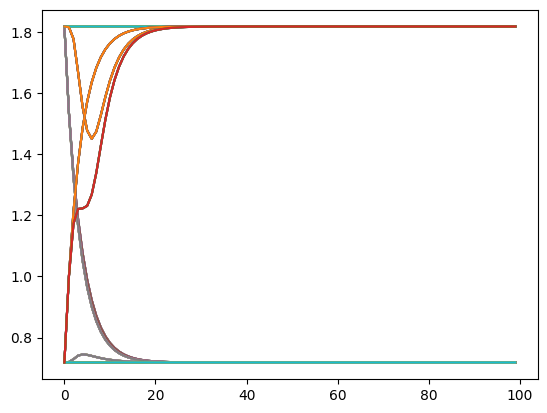

In [9]:
emt = F_func(n, par, gamma)
emt_scipy = lambda x, t : emt(x)

allx = list(itertools.product(*zip(xminus, xplus)))

for i in range(2**6):
    y = scipy.integrate.odeint(emt_scipy, allx[i], np.linspace(0,50,100))
    if i == 0:
        equilibria = np.array([[y[-1,:]]])
    else:
        equilibria = np.append(equilibria, y[-1,:])
    plt.plot(y[:,0])
    #plt.show()
plt.show()

# The Hill function w.r.t. the switching function

/var/folders/nq/lv0cxwc9499c381g1gblftdm0000gn/T/ipykernel_74091/2800848579.py:19: RuntimeWarning: overflow encountered in scalar power
  return ell + delta /((theta/x)**n + 1)
/var/folders/nq/lv0cxwc9499c381g1gblftdm0000gn/T/ipykernel_74091/2800848579.py:19: RuntimeWarning: overflow encountered in scalar power
  return ell + delta /((theta/x)**n + 1)


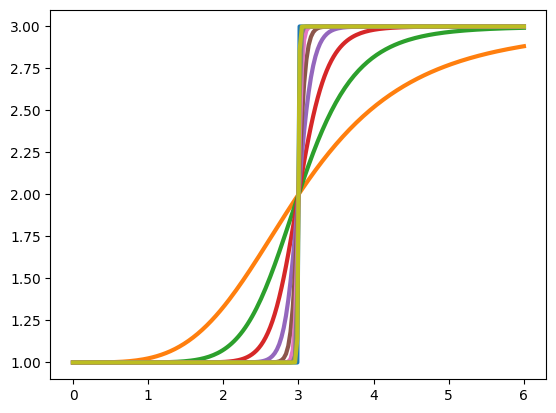

In [24]:
ell, delta, theta = 1,2,3

heavy = lambda x : ell + delta * (x>theta)

x = np.linspace(0, 2*theta, 200)




plt.plot(x, heavy(x), linewidth='3')
for i in range(2, 10):
    n = 2.**i
    
    def H(x):
        if x == 0:
            return ell
        if theta == 0:
            return ell + delta 
        return ell + delta /((theta/x)**n + 1)
    plt.plot(x, [H(xi) for xi in x],linewidth='3')
plt.savefig('Hill_and_switch')

# Parameter regions

Toggle Switch parameter regions representation

In [10]:
# assumed parameter order = gamma1, ell1, delta1, theta1, gamma2, ell2, delta2, theta2

def horizontal_index(par):
    gamma, ell, delta, a, b, c, d, theta = par[:]
    if gamma * theta < ell:
        return 0
    if gamma * theta < ell + delta:
        return 1
    return 2

def vertical_index(par):
    a, b, c, theta, gamma, ell, delta, d = par[:]
    if gamma * theta < ell:
        return 0
    if gamma * theta < ell + delta:
        return 1
    return 2

def region_number(par):
    hi = horizontal_index(par)
    vi = vertical_index(par)
    I = np.reshape(range(1,10), [3,3])
    return I[hi, vi]

par = [1,2,3,2,5,6,7,1]
#horizontal_index(par)
#vertical_index(par)
region_number(par)

2

In [11]:
cmap = plt.cm.get_cmap('Spectral')

rgba = cmap(0.5)

def color(par):
    number = region_number(par)
    return cmap(number/9)
    

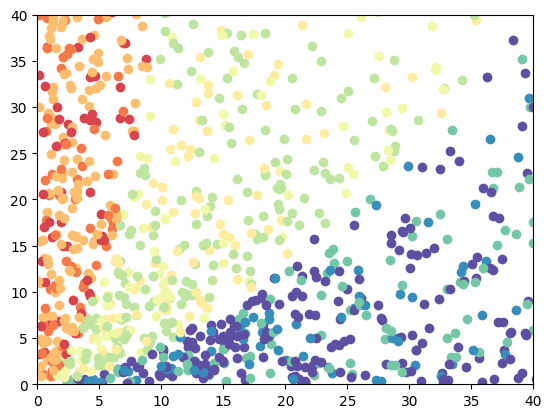

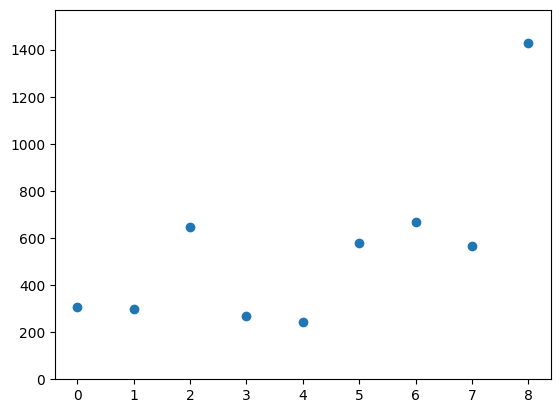

[ 305.  300.  646.  269.  242.  579.  667.  565. 1427.]


In [12]:
size = 5000
random_2D = np.random.lognormal(mean=4., sigma=2., size=[size,4])
distribution = np.zeros(9)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(size):
    par2D = random_2D[i,:]
    par = np.array([par2D[0],1.75*par2D[1],7*par2D[1], np.sqrt(par2D[2]+par2D[3]),
                    par2D[2],1.75*par2D[3],7*par2D[3], np.sqrt(par2D[0]+par2D[1])])
    plt.scatter(par2D[0],par2D[1],color=color(par)) 
    distribution[region_number(par)-1] += 1

ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
plt.savefig('2Dbanana_regions')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(distribution, 'o')
ax.set_ylim(0, 1.1*np.max(distribution))
plt.show()
print(distribution)

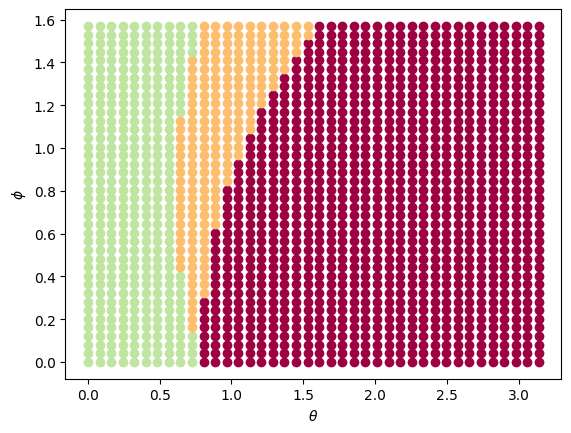

In [152]:
def spherical_region(theta, phi):
    gamma = np.cos(theta)
    ell = np.sin(theta) * np.cos(phi)
    delta = np.sin(theta) * np.sin(phi)
    if gamma < ell :
        return 0
    if gamma < ell + delta:
        return 1
    return 2

def spherical_color(theta, phi):
    number = spherical_region(theta, phi)
    return cmap(number/3)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

size = 40
for i in np.linspace(0, np.pi, size):
    for j in np.linspace(0, np.pi/2, size):
        plt.scatter(i,j,color=spherical_color(i,j)) 
    
ax.set_xlabel(r'$\theta$')  # Add an x-label to the axes.
ax.set_ylabel(r'$\phi$')  # Add a y-label to the axes.
fig.savefig('spherical_banana_projection')

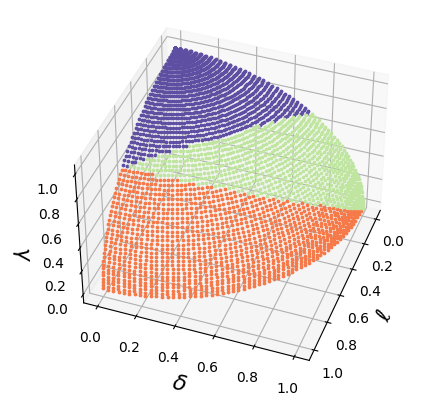

In [176]:
def spherical_region(theta, phi):
    gamma = np.cos(theta)
    ell = np.sin(theta) * np.cos(phi)
    delta = np.sin(theta) * np.sin(phi)
    if gamma < ell :
        return 0
    if gamma < ell + delta:
        return 1
    return 2

def spherical_color(theta, phi):
    number = spherical_region(theta, phi)
    if number == 0:
        return cmap(2/9)
    if number == 1:
        return cmap(6/9)
    return cmap(9/9)
#    return cmap(number/3)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

size = 60
for i in np.linspace(0, np.pi/2, size):
    for j in np.linspace(0, np.pi/2, size):
        gamma = np.cos(i)
        ell = np.sin(i) * np.cos(j)
        delta = np.sin(i) * np.sin(j)
        ax.scatter(ell, delta, gamma,color=spherical_color(i,j), s=3) 
    
ax.set_xlabel(r'$\ell$', fontsize=16)  # Add an x-label to the axes.
ax.set_ylabel(r'$\delta$', fontsize=16)  # Add a y-label to the axes.
ax.set_zlabel(r'$\gamma$', fontsize=16)  # Add a y-label to the axes.
ax.view_init(elev=40., azim = 20.)
fig.savefig('spherical_banana3D')